In [1]:
import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import os

In [2]:
if torch.cuda.is_available():
    _device = 'cuda'
elif torch.backends.mps.is_available():
    _device = 'mps'
else:
    _device = 'cpu'

_device

'mps'

In [3]:
device = torch.device(_device)
device

device(type='mps')

In [4]:
# Values computed on
# https://github.com/seafoodfry/ml-workspace/blob/main/gpu-sandbox/vision/cnns/svhn-intro.ipynb
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        (0.4377, 0.4438, 0.4728),
        (0.1980, 0.2010, 0.1970),
    )
])

In [5]:
train_dataset = torchvision.datasets.SVHN(
    root='./data', 
    split='train', 
    download=True, 
    transform=transform
)

test_dataset = torchvision.datasets.SVHN(
    root='./data', 
    split='test', 
    download=True, 
    transform=transform,
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 182M/182M [00:22<00:00, 7.97MB/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64.3M/64.3M [00:10<00:00, 6.00MB/s]


In [12]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True) #, num_workers=os.cpu_count())
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [13]:
class _SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        # Max pooling layer (most common)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Another conv + pooling combination
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully connected layer for classification
        self.fc = nn.Linear(32 * 8 * 8, 10)  # Assuming input image was 32x32


    def forward(self, x):
        # Apply conv + ReLU + pooling
        x = torch.relu(self.conv1(x))
        x = self.pool1(x)
        
        # Second conv + ReLU + pooling
        x = torch.relu(self.conv2(x))
        x = self.pool2(x)
        
        # Flatten for the fully connected layer
        x = x.view(-1, 32 * 8 * 8)
        
        # Final classification layer
        x = self.fc(x)
        return x


class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        """
        For a convolutional layer, the output size is calculated as:

            Output size = (Input size - Kernel size + 2 * Padding) / Stride + 1
            
        The general rule: to preserve spatial dimensions, the padding should be:
            Padding = (Kernel size - 1) / 2
        """
        # Feature extractor using Sequential.
        self.features = nn.Sequential(
            # - in_channels=3: This is determined by your input data. SVHN images are RGB,
            #     so they have 3 color channels.
            # - padding=1: This preserves the spatial dimensions. With a 3×3 kernel,
            #     padding=1 ensures the output has the same height/width as the input.
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # - in_channels=16: This must match the out_channels from the previous layer.
            # - out_channels=32: Another design choice - typically we increase the number
            #     of channels as we go deeper.
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Classifier using Sequential.
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # SVHN are 32x32x8.
            # After first conv+pool: 16×16×16 (halved spatial dimensions due to pooling,
            #  16 in the 3rd channel because that was our out_channels value.)
            # After second conv+pool: 8×8×32 (halved spatial dimensions again, and double due to
            #   our choice of out_channels in the 2nd conv layer.)
            # 10 because it is the number of classes we are training on.
            nn.Linear(32 * 8 * 8, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [14]:
# Move model to device.
model = SimpleCNN().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop.
model.train()
num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for batch_idx, (features, labels) in enumerate(train_loader):
        features, labels = features.to(device), labels.to(device)
        
        # Zero the gradients.
        optimizer.zero_grad()
        
        logits = model(features)
        loss = criterion(logits, labels)

        # Backward pass and optimize.
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Print statistics.
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.5f}')

# Optional: Validation loop
model.eval()
# ... validation code here

Epoch 1/10, Loss: 0.82650
Epoch 2/10, Loss: 0.50493
Epoch 3/10, Loss: 0.43586
Epoch 4/10, Loss: 0.39508
Epoch 5/10, Loss: 0.36784
Epoch 6/10, Loss: 0.34890
Epoch 7/10, Loss: 0.33286
Epoch 8/10, Loss: 0.31898
Epoch 9/10, Loss: 0.30773
Epoch 10/10, Loss: 0.29809


SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2048, out_features=10, bias=True)
  )
)

In [15]:
torch.save(model.state_dict(), 'simple_cnn_model.pth')
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': epoch,
    'loss': loss,
}, 'simple_cnn_checkpoint.pth')

In [16]:
model = SimpleCNN()
model.load_state_dict(torch.load('simple_cnn_model.pth', map_location=device))
model = model.to(device)
model.eval()

SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2048, out_features=10, bias=True)
  )
)

In [ ]:
# If you want to resume training.
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

checkpoint = torch.load('simple_cnn_checkpoint.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

# Now switch to train mode and continue training
model.train()

num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for batch_idx, (features, labels) in enumerate(train_loader):
        features, labels = features.to(device), labels.to(device)
        
        # Zero the gradients.
        optimizer.zero_grad()
        
        logits = model(features)
        loss = criterion(logits, labels)

        # Backward pass and optimize.
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Print statistics.
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.5f}')
    
# Optional: Validation loop
model.eval()

In [17]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

In [18]:
def evaluate_model(model, test_loader, device):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():  # Disable gradient calculation.
        for images, labels in tqdm(test_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            # The outputs, logits, are of shape [batch_size, num_classes].
            predictions = torch.argmax(outputs, dim=1)
            correct += torch.sum( predictions == labels ).item()                    
            total += labels.size(0)
            
            # Store predictions and labels for confusion matrix.
            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')
    
    return all_preds, all_labels, accuracy

In [19]:
predictions, true_labels, accuracy = evaluate_model(model, test_loader, device)

  0%|          | 0/407 [00:00<?, ?it/s]

Test Accuracy: 86.59%


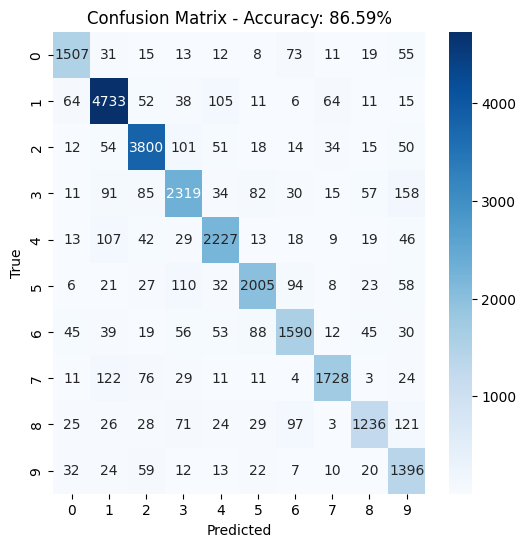

In [20]:
# Confusion Matrix.
cm = confusion_matrix(true_labels, predictions)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix - Accuracy: {accuracy:.2f}%')
#plt.savefig('confusion_matrix.png')
plt.show()

In [21]:
print("\nClassification Report:")
print(classification_report(true_labels, predictions))


Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.86      0.87      1744
           1       0.90      0.93      0.91      5099
           2       0.90      0.92      0.91      4149
           3       0.83      0.80      0.82      2882
           4       0.87      0.88      0.88      2523
           5       0.88      0.84      0.86      2384
           6       0.82      0.80      0.81      1977
           7       0.91      0.86      0.88      2019
           8       0.85      0.74      0.80      1660
           9       0.71      0.88      0.79      1595

    accuracy                           0.87     26032
   macro avg       0.86      0.85      0.85     26032
weighted avg       0.87      0.87      0.87     26032



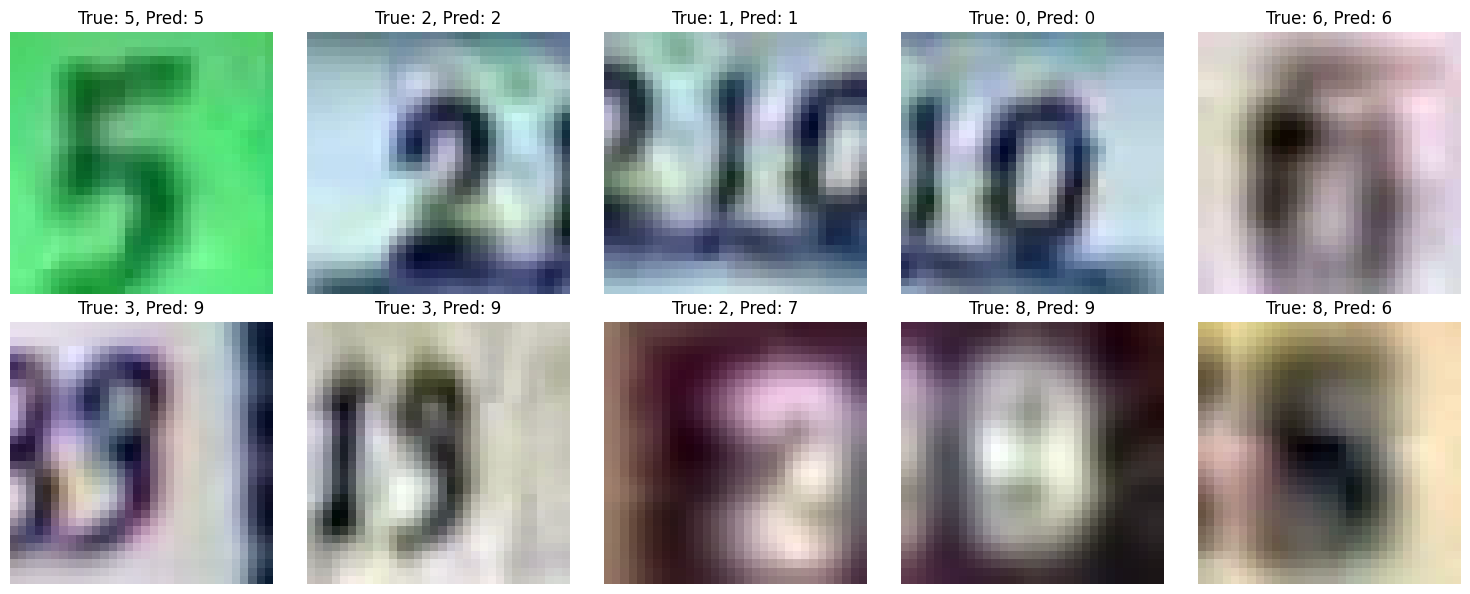

In [22]:
def show_examples(model, test_loader, device, num_examples=5):
    """
    The permute function in PyTorch is used to rearrange the dimensions of a tensor.
    In this context, it's converting the image tensor from PyTorch's standard channel-first
    format to the channel-last format expected by matplotlib's imshow function.
    
    PyTorch image tensors are typically shaped as [channels, height, width]:
    For RGB images: [3, H, W]
    
    But matplotlib's imshow expects images in [height, width, channels] format:
    For RGB images: [H, W, 3]
    """
    model.eval()
    fig, axes = plt.subplots(2, num_examples, figsize=(15, 6))
    
    correct_count = 0
    incorrect_count = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            
            for i in range(len(images)):
                if correct_count < num_examples and preds[i] == labels[i]:
                    # Process image for display
                    img = images[i].cpu().permute(1, 2, 0)
                    
                    # Normalize image for display
                    img = img - img.min()
                    img = img / (img.max() + 1e-8)  # Add small epsilon to avoid division by zero
                    
                    # Show correct prediction
                    axes[0, correct_count].imshow(img)
                    axes[0, correct_count].set_title(f'True: {labels[i].item()}, Pred: {preds[i].item()}')
                    axes[0, correct_count].axis('off')
                    correct_count += 1
                
                if incorrect_count < num_examples and preds[i] != labels[i]:
                    # Process image for display
                    img = images[i].cpu().permute(1, 2, 0)
                    
                    # Normalize image for display
                    img = img - img.min()
                    img = img / (img.max() + 1e-8)
                    
                    # Show incorrect prediction
                    axes[1, incorrect_count].imshow(img)
                    axes[1, incorrect_count].set_title(f'True: {labels[i].item()}, Pred: {preds[i].item()}')
                    axes[1, incorrect_count].axis('off')
                    incorrect_count += 1
            
            if correct_count >= num_examples and incorrect_count >= num_examples:
                break
    
    plt.tight_layout()
    #plt.savefig('prediction_examples.png')
    plt.show()

# Show examples of predictions
show_examples(model, test_loader, device)